 # **Semivariances → MHAR‑ReCov Spillovers**



 End‑to‑end, reproducible code that:



 1. Loads intraday day‑ahead electricity prices *(Europe / Australia)*

 2. Computes hourly **simple returns**

 3. Aggregates to daily **positive** and **negative** realised semicovariance matrices (ReCov⁺, ReCov⁻)

 4. Converts each matrix to its *vech* vector

 5. Applies a **Probability‑Integral Transform (PIT)** element‑wise to stabilise variances

 6. Saves intermediary Parquet artefacts

 7. Runs two MHAR‑ReCov LASSO spillover analyses – one for ReCov⁺, one for ReCov⁻ –

    and prints previews (`head()`) plus Total Spillover Indices.







In [1]:
# Imports & global config
import os, json, random, warnings
from scipy.stats import norm, rankdata
import numpy as np, pandas as pd
from tqdm.notebook import tqdm
from pathlib import Path

# ML / stats
from sklearn.model_selection import KFold
from sklearn.linear_model import MultiTaskLasso, MultiTaskLassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from utils.mhar_utils import FAST_LASSO_OPTS, create_mhar_lags, gvd, spillover_metrics, fit_mhar_lasso

# Display helpers (Jupyter)
import ipywidgets as widgets
from IPython.display import display, Markdown

warnings.filterwarnings('ignore')
SEED = 12345
np.random.seed(SEED); random.seed(SEED)


 ## 0 · Choose study area

 Pick between the European or Australian dataset. Subsequent cells read

 `area_dd.value`, so re‑running a cell after changing the dropdown automatically

 recomputes that step with the new selection.

In [2]:
area_dd = widgets.Dropdown(options=["europe", "australia"], value="europe", description="Dataset:")
display(area_dd)

# Convenience alias used by subsequent cells -----------------------------------
get_area = lambda: area_dd.value


Dropdown(description='Dataset:', options=('europe', 'australia'), value='europe')

 ## 1 · Helpers: data loading, returns, display utilities

In [3]:
PRICES_PATHS = {
    "europe":    "parquet_files/filtered_data.parquet",
    "australia": "parquet_files/filtered_data_australia.parquet",
}

# ---------------------------------------------------------------------------
# Generic preview printer
# ---------------------------------------------------------------------------

def show(title, obj, n=5):
    """Pretty‑print a markdown title + DataFrame/Series preview."""
    display(Markdown(f"### {title}"))
    if isinstance(obj, dict):      # show first item when dict of DFs
        k, v = next(iter(obj.items()))
        display(Markdown(f"*First key:* **{k}**"))
        display(v.head(n))
    else:
        display(obj.head(n))

# ---------------------------------------------------------------------------
# ETL helpers
# ---------------------------------------------------------------------------

def load_prices(area: str) -> pd.DataFrame:
    """Return wide price DataFrame (index = timestamp, columns = areas)."""
    df = (
        pd.read_parquet(PRICES_PATHS[area])
          .sort_values(["Area", "Start DateTime"])
    )
    wide = (
        df.pivot(index="Start DateTime", columns="Area", values="Day-ahead Price (EUR/MWh)")
          .sort_index()
    )
    return wide


def simple_returns(prices):
    ret = prices.diff().dropna()
    ret = ret.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    ret["Date"] = ret.index.date
    return ret




 ## 2 · Helpers: semicovariances, vectorisation, transforms

In [4]:
# ---------------------------------------------------------------------------
# Daily realised semicovariances (ReCov⁺ / ReCov⁻)
# ---------------------------------------------------------------------------

def daily_semicov(ret: pd.DataFrame):
    pos, neg = {}, {}
    for day, grp in tqdm(ret.groupby("Date"), desc="daily semicov"):
        r = grp.drop(columns="Date")
        T, N = r.shape
        cov_p = np.zeros((N, N))
        cov_n = np.zeros((N, N))
        m_plus = np.zeros((N, N))
        m_minus = np.zeros((N, N))

        for row in r.values:
            rp = np.clip(row, 0, None)
            rn = np.clip(row, None, 0)
            cov_p += np.outer(rp, rp)
            cov_n += np.outer(rn, rn)
            m_plus += np.outer(rp, rn)
            m_minus += np.outer(rn, rp)

        # Optionally, divide by T or just leave as sums (PIT will normalize scale)
        # cov_p /= T; cov_n /= T; m_plus /= T; m_minus /= T

        # For ReCov+ (positive semi), take cov_p + m_plus
        # For ReCov- (negative semi), take cov_n + m_minus

        cols = r.columns
        pos[day] = pd.DataFrame(cov_p + m_plus, index=cols, columns=cols)
        neg[day] = pd.DataFrame(cov_n + m_minus, index=cols, columns=cols)

    return pos, neg


# ---------------------------------------------------------------------------
# vech vectorisation 
# ---------------------------------------------------------------------------
def build_vech_dataframe(cov_dict):
    areas = list(next(iter(cov_dict.values())).columns)     # ['NSW','QLD',...]
    pairs = [f"{b}-{a}" for a in areas for b in areas if b > a]  # TAS-NSW,…

    labels, records, dates = areas + pairs, [], []
    for d, mat in cov_dict.items():
        vec  = [mat.loc[a, a] for a in areas]                    # varianzas
        vec += [mat.loc[b, a] for a in areas for b in areas if b > a]
        records.append(vec);  dates.append(d)

    df = pd.DataFrame(records, index=pd.to_datetime(dates), columns=labels)
    return df, labels


def pit_transform(df):
    ranks = df.rank(axis=0, method="average")
    U     = ranks.div(len(df) + 1)
    return pd.DataFrame(norm.ppf(U), index=df.index, columns=df.columns)


# ---------------------------------------------------------------------------
# MHAR‑ReCov spillover estimation (PIT + estandarización)  — H = 1
# ---------------------------------------------------------------------------
def mhar_spillover(pit_path: str, area: str):
    """
    Ajusta un MHAR‑ReCov con LASSO multirrespuesta sobre datos PIT ya
    centrados/estandarizados (igual que glmnet en R) y devuelve la tabla
    GFEVD en % y el TSI.
    """
    pit_df = pd.read_parquet(pit_path)
    with open(f"parquet_files/vech_labels_{area}.json") as f:
        pit_df.columns = json.load(f)

    # 1 · Regresores HAR centrados
    X_full = create_mhar_lags(pit_df)
    X      = X_full.drop(columns=pit_df.columns)
    Y = pit_df.loc[X.index]

    # 2 · Pipeline: StandardScaler → MultiTaskLassoCV
    pipe = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        MultiTaskLassoCV(**FAST_LASSO_OPTS)
    )
    pipe.fit(X, Y)
    mtl = pipe.named_steps['multitasklassocv']

    # 3 · Betas y Φ₁
    B, ints = mtl.coef_, mtl.intercept_          # (K, 3K)  y (K,)
    Bd, Bw, Bm = np.split(B, 3, axis=1)
    Phi1 = Bd + Bw/7 + Bm/30

    # 4 · Residuales y Σ
    Y_hat = pipe.predict(X)
    resid = Y.values - Y_hat
    Sigma = resid.T @ resid / resid.shape[0]

    # 5 · FEVD (Pesaran–Shin) via util gvd
    K        = Y.shape[1]
    theta, θ = gvd([np.eye(K), Phi1], Sigma)      # θ = row-normalised

    # 6 · TSI
    tsi, *_  = spillover_metrics(θ)

    fevd_pct = pd.DataFrame(θ*100, index=Y.columns, columns=Y.columns)
    return fevd_pct, tsi



# ---------------------------------------------------------------------------
# Optional: save daily semicovariances in long format ------------------------
# ---------------------------------------------------------------------------

def flat_save(cov_dict, tag, area):
    rows = []
    for d, mat in cov_dict.items():
        for i, a in enumerate(mat.index):
            for j, b in enumerate(mat.columns):
                rows.append({"Date": d, "Market1": a, "Market2": b, "Value": mat.iloc[i, j]})
    pd.DataFrame(rows).to_parquet(f"parquet_files/daily_semicov_{tag}_{area}.parquet")

# Ensure output directory exists -------------------------------------------
os.makedirs("parquet_files", exist_ok=True)



# ---------------------------------------------------------------
# util ▸ limpiar nombres + reordenar filas/columnas
# ---------------------------------------------------------------
def reorder_spillover(df, raw_areas):
    pairs = [f"{b}-{a}" for a in raw_areas for b in raw_areas if b > a]
    order = raw_areas + pairs
    return df.loc[order, order]



 ## 3 · Load intraday prices → hourly simple returns

 Run this cell to ingest the raw day‑ahead price data and compute hourly

 log‑returns.

In [5]:
# 1 · Load prices ------------------------------------------------------------
prices = load_prices(get_area())
show("Intraday prices", prices)

# 2 · Hourly log‑returns -----------------------------------------------------
rets = simple_returns(prices)
show("Hourly simple returns", rets)


### Intraday prices

Area,nsw,qld,sa,tas,vic
Start DateTime,,,,,
2009-07-01 00:00:00,16.941263,17.650000,16.730280,15.671540,15.50000
2009-07-01 00:05:00,17.709524,18.810089,17.820490,16.057039,15.50000
2009-07-01 00:10:00,17.678644,18.617599,18.123159,15.902460,15.39000
2009-07-01 00:15:00,16.736212,18.611300,17.623659,14.273130,12.81297
2009-07-01 00:20:00,15.638840,17.650000,16.334089,13.241490,11.80000


### Hourly simple returns

Area,nsw,qld,sa,tas,vic,Date
Start DateTime,,,,,,
2009-07-01 00:05:00,0.768261,1.160089,1.090210,0.385499,0.00000,2009-07-01
2009-07-01 00:10:00,-0.030880,-0.192490,0.302669,-0.154579,-0.11000,2009-07-01
2009-07-01 00:15:00,-0.942432,-0.006299,-0.499500,-1.629330,-2.57703,2009-07-01
2009-07-01 00:20:00,-1.097372,-0.961300,-1.289570,-1.031640,-1.01297,2009-07-01
2009-07-01 00:25:00,-1.910073,-1.923970,-4.372559,-2.112760,1.06755,2009-07-01


 ## 4 · Intraday → daily ReCov⁺ / ReCov⁻ semicovariances

In [6]:
pos, neg = daily_semicov(rets)
show("ReCov⁺ (first day)", pos)
show("ReCov⁻ (first day)", neg)

# Optional long‑format save (uncomment if needed) ---------------------------
# flat_save(pos, "pos", get_area())
# flat_save(neg, "neg", get_area())


daily semicov:   0%|          | 0/3530 [00:00<?, ?it/s]

### ReCov⁺ (first day)

*First key:* **2009-07-01**

Area,nsw,qld,sa,tas,vic
Area,,,,,
nsw,610.588825,243.949303,896.602764,1313.744451,321.916446
qld,231.466893,239.130080,89.983677,357.120262,213.808685
sa,903.210010,186.179659,3236.679679,543.797443,325.664518
tas,1320.259527,375.179927,530.008942,4717.445965,549.077156
vic,312.496366,217.792900,268.960987,517.108733,312.548439


### ReCov⁻ (first day)

*First key:* **2009-07-01**

Area,nsw,qld,sa,tas,vic
Area,,,,,
nsw,625.114683,231.666146,816.005548,1513.349879,302.360545
qld,244.148556,236.393949,195.057745,294.674944,234.477808
sa,809.398303,98.861764,3124.609033,490.975000,220.295498
tas,1506.834803,276.615279,504.763501,5978.828806,449.009071
vic,311.780626,230.493593,276.999030,480.977493,307.292570


 ## 5 · vech vectorisation + PIT transform

In [7]:
# vech vectorisation ---------------------------------------------------------
v_pos, labels = build_vech_dataframe(pos)
v_neg, _      = build_vech_dataframe(neg)
show("vech ReCov⁺", v_pos)
show("vech ReCov⁻", v_neg)

# PIT transform -------------------------------------------------------------
pit_pos = pit_transform(v_pos)
pit_neg = pit_transform(v_neg)
show("PIT ReCov⁺", pit_pos)
show("PIT ReCov⁻", pit_neg)

# Save Parquet artefacts -----------------------------------------------------
path_pos = f"parquet_files/pit_vech_pos_{get_area()}.parquet"
path_neg = f"parquet_files/pit_vech_neg_{get_area()}.parquet"

pit_pos.to_parquet(path_pos)
pit_neg.to_parquet(path_neg)
with open(f"parquet_files/vech_labels_{get_area()}.json", "w") as f:
    json.dump(labels, f)


### vech ReCov⁺

,nsw,qld,sa,tas,vic,qld-nsw,sa-nsw,tas-nsw,vic-nsw,sa-qld,tas-qld,vic-qld,tas-sa,vic-sa,vic-tas
2009-07-01,610.588825,239.130080,3236.679679,4717.445965,312.548439,231.466893,903.210010,1320.259527,312.496366,186.179659,375.179927,217.792900,530.008942,268.960987,517.108733
2009-07-02,23178.296516,165524.863562,6257.880670,5279.371343,8985.550303,44783.588360,4367.980238,3573.303725,5882.775382,321.865695,732.828114,802.140581,3090.275304,6244.893133,4448.650614
2009-07-03,824.975591,882.421731,945.697272,1130.345110,1037.074145,807.558367,845.337319,610.502208,892.964526,830.517949,414.865828,923.596354,497.574050,948.325121,467.459047
2009-07-04,697.208237,453.017406,712.193199,4450.235225,622.702592,476.450985,574.106135,1291.158050,567.721131,471.887540,465.309879,516.881465,471.085190,574.154649,527.810160
2009-07-05,2748.989500,2569.863281,2667.054198,3160.411234,2725.962627,2634.620823,2691.936643,2748.063568,2714.500781,2591.345770,2523.036917,2617.063303,2604.735280,2672.181195,2625.622226


### vech ReCov⁻

,nsw,qld,sa,tas,vic,qld-nsw,sa-nsw,tas-nsw,vic-nsw,sa-qld,tas-qld,vic-qld,tas-sa,vic-sa,vic-tas
2009-07-01,625.114683,236.393949,3124.609033,5978.828806,307.292570,244.148556,809.398303,1506.834803,311.780626,98.861764,276.615279,230.493593,504.763501,276.999030,480.977493
2009-07-02,13330.223976,148754.613500,5192.200250,5123.733804,8673.800045,34116.756993,4316.262084,2731.666351,6358.957223,-276.121781,1141.703403,45.825421,1283.404625,5815.927519,2954.557308
2009-07-03,521.716314,628.928107,530.292419,900.063547,585.900004,488.252898,480.989498,540.108369,530.308122,380.381578,383.701082,476.246658,460.525712,508.829479,476.496332
2009-07-04,486.142863,290.400972,452.610544,4728.454849,402.414935,283.287976,347.329106,1135.679674,341.150410,285.959202,149.392810,325.541167,344.790233,369.151925,231.153361
2009-07-05,2463.089792,2368.154441,2502.357760,3039.265622,2423.627253,2381.976200,2443.413317,2447.162618,2425.992895,2388.332758,2198.937360,2367.902810,2280.993486,2429.071409,2292.633978


### PIT ReCov⁺

,nsw,qld,sa,tas,vic,qld-nsw,sa-nsw,tas-nsw,vic-nsw,sa-qld,tas-qld,vic-qld,tas-sa,vic-sa,vic-tas
2009-07-01,-0.715846,-1.288196,-0.092061,-0.051490,-0.905245,-0.929028,-0.344233,-0.157176,-0.644271,-0.629490,-0.008164,-0.592696,-0.074252,-0.705792,-0.079236
2009-07-02,0.343480,1.056874,0.067135,-0.015973,0.444007,0.806923,0.112042,0.209158,0.382149,-0.377571,0.214240,-0.031595,0.458942,0.386735,0.583414
2009-07-03,-0.579211,-0.486728,-0.481938,-0.630355,-0.214240,-0.304573,-0.372240,-0.488326,-0.145687,-0.018103,0.025204,0.021653,-0.101333,-0.124195,-0.111328
2009-07-04,-0.652154,-0.839802,-0.622581,-0.083509,-0.451855,-0.514894,-0.518139,-0.162928,-0.329956,-0.217874,0.067135,-0.187438,-0.121334,-0.310528,-0.072116
2009-07-05,-0.206982,-0.104901,-0.139949,-0.208433,0.087784,0.020943,-0.016683,0.119903,0.164367,0.318733,0.590160,0.331456,0.417523,0.175170,0.438529


### PIT ReCov⁻

,nsw,qld,sa,tas,vic,qld-nsw,sa-nsw,tas-nsw,vic-nsw,sa-qld,tas-qld,vic-qld,tas-sa,vic-sa,vic-tas
2009-07-01,-0.685897,-1.239294,-0.093487,0.038699,-0.890374,-0.876738,-0.369199,-0.089922,-0.610562,-0.926844,-0.066424,-0.558347,-0.040120,-0.632955,-0.091348
2009-07-02,0.207707,1.029957,0.030885,-0.025914,0.436186,0.709440,0.101333,0.115614,0.401312,-1.467760,0.409018,-1.307978,0.249244,0.376809,0.481938
2009-07-03,-0.770110,-0.641652,-0.752091,-0.728746,-0.462889,-0.471599,-0.585098,-0.530356,-0.338965,-0.283078,0.060733,-0.218601,-0.076388,-0.313509,-0.094200
2009-07-04,-0.809875,-1.097452,-0.833757,-0.055755,-0.677836,-0.779695,-0.766296,-0.206982,-0.557518,-0.408247,-0.294179,-0.371480,-0.212062,-0.473980,-0.415201
2009-07-05,-0.220782,-0.124910,-0.155020,-0.217147,0.073540,0.005324,-0.055755,0.087784,0.142817,0.290475,0.613987,0.300858,0.406704,0.170126,0.409018


 ## 6 · MHAR‑ReCov spillover analyses

 Run the next cell to estimate the MHAR‑ReCov models for the positive and

 negative semicovariance series, display the spillover tables, and report the

 Total Spillover Indices (TSI).

In [8]:
# ----------------------------------------------------------------
# 6 ·  MHAR-ReCov spillover analyses
# ----------------------------------------------------------------
spill_p, tsi_p = mhar_spillover(path_pos, get_area())   # ReCov⁺
spill_n, tsi_n = mhar_spillover(path_neg, get_area())   # ReCov⁻


# --------------------------------------------------------------
#  precios.columns conserva el orden “natural” de las zonas
raw_areas = prices.columns.tolist()

spill_p = reorder_spillover(spill_p, raw_areas)
spill_n = reorder_spillover(spill_n, raw_areas)


for df in (spill_p, spill_n):
    # ----- 1 ▸ métricas (antes de añadir columnas) -----------------
    diag = np.diag(df)                         # (15,)
    from_vec = df.sum(axis=1) - diag           # (15,)
    to_vec   = df.sum(axis=0) - diag           # (15,)
    grand_to = to_vec.sum()                    # 1001.05 / 1017.66

    # ----- 2 ▸ columna “Directional FROM others” ------------------
    df["Directional FROM others"] = from_vec

    # ----- 3 ▸ fila “Directional TO others” -----------------------
    df.loc["Directional TO others"] = pd.Series(
        list(to_vec) + [grand_to],             # 15 + gran total = 16
        index=df.columns                       # ya contiene la nueva col.
    )

    # ----- 4 ▸ fila “NET Directional” -----------------------------
    df.loc["NET Directional"] = (
        df.loc["Directional TO others"] - df["Directional FROM others"]
    )



# (a partir de aquí todo igual)
show("Spillover table – ReCov⁺", spill_p.round(2))
show("Total Spillover Index (TSI⁺)", pd.Series({"TSI+": tsi_p}))

show("Spillover table – ReCov⁻", spill_n.round(2))
show("Total Spillover Index (TSI⁻)", pd.Series({"TSI-": tsi_n}))


### Spillover table – ReCov⁺

,nsw,qld,sa,tas,vic,qld-nsw,sa-nsw,tas-nsw,vic-nsw,sa-qld,tas-qld,vic-qld,tas-sa,vic-sa,vic-tas,Directional FROM others
nsw,26.18,12.13,11.81,5.75,8.64,8.43,9.79,3.15,4.11,0.77,0.81,1.21,1.43,3.36,2.42,73.82
qld,15.82,35.23,2.06,1.17,5.40,23.74,1.93,0.73,3.29,2.17,1.03,2.49,0.97,2.59,1.38,64.77
sa,13.08,1.64,30.13,2.48,13.16,1.09,21.84,1.20,4.81,0.56,0.53,1.15,1.16,4.09,3.06,69.87
tas,8.33,1.09,3.55,37.40,6.52,0.57,2.89,22.31,3.94,0.40,1.47,0.65,3.69,3.20,3.98,62.60
vic,7.63,3.37,11.08,3.88,25.04,2.32,9.14,2.68,12.01,1.61,0.95,2.76,3.00,9.83,4.70,74.96


### Total Spillover Index (TSI⁺)

TSI+    66.595313
dtype: float64

### Spillover table – ReCov⁻

,nsw,qld,sa,tas,vic,qld-nsw,sa-nsw,tas-nsw,vic-nsw,sa-qld,tas-qld,vic-qld,tas-sa,vic-sa,vic-tas,Directional FROM others
nsw,25.03,11.45,11.34,5.53,8.39,8.18,10.81,3.32,4.24,2.18,0.86,2.09,1.35,2.59,2.64,74.97
qld,15.11,34.01,2.00,1.10,5.27,22.83,2.32,1.07,3.87,2.71,1.29,3.57,1.29,2.27,1.29,65.99
sa,13.18,1.66,29.98,2.58,13.52,0.91,22.32,1.12,3.98,1.64,0.61,1.20,1.12,3.11,3.07,70.02
tas,8.22,1.04,3.57,36.99,6.68,0.78,3.63,21.59,4.19,0.66,0.82,0.86,3.01,3.07,4.89,63.01
vic,7.71,3.36,11.29,4.02,25.02,2.24,9.52,2.72,10.99,2.56,0.94,2.87,3.32,8.66,4.78,74.98


### Total Spillover Index (TSI⁻)

TSI-    67.664095
dtype: float64

## Table


In [9]:
# ----------------------------------------------------------------
# 1 ▸ helper to construct a nicely-formatted table  -------------- 
# ----------------------------------------------------------------
def tidy_spillover(df: pd.DataFrame, tsi: float) -> str:
    """
    Round, remove redundant headers, add bold TSI, and convert
    a spillover DataFrame to a LaTeX tabular (booktabs style).
    """
    tbl = df.round(2).copy()
    tbl.index.name, tbl.columns.name = None, None

    # Replace bottom-right cell with bold Total Spillover Index
    tbl.loc["NET Directional", "Directional FROM others"] = (
        rf"\textbf{{TSI = {tsi:.2f}}}"
    )
    # Keep the text string as-is inside a numeric frame
    tbl = tbl.astype(object)

    # Column spec: one stub column (l) + numeric columns (r … r)
    col_spec = "l" + "r" * tbl.shape[1]

    try:                              # pandas ≥ 1.5: hrules available
        latex_body = tbl.to_latex(
            index=True,
            index_names=False,
            escape=False,
            na_rep="",
            column_format=col_spec,
            float_format="%.2f",
            hrules=True               # ⇒ \toprule, \midrule, \bottomrule
        )
    except TypeError:                 # fallback for older pandas
        latex_body = tbl.to_latex(
            index=True,
            index_names=False,
            escape=False,
            na_rep="",
            column_format=col_spec,
            float_format="%.2f"
        )
        # crude swap of first / last \hline for booktabs look-alike
        latex_body = (
            latex_body
            .replace(r"\hline", r"\toprule", 1)
            .replace(r"\hline", r"\bottomrule", 1)
        )
    return latex_body

In [10]:
# ----------------------------------------------------------------
# 2 ▸ build both panels  -----------------------------------------
# ----------------------------------------------------------------
# ⇣⇣  THESE come from your earlier code  ⇣⇣
#   spill_p : pd.DataFrame   # ReCov⁺ spillovers
#   tsi_p   : float          # Total Spillover Index (ReCov⁺)
#   spill_n : pd.DataFrame   # ReCov⁻ spillovers
#   tsi_n   : float          # Total Spillover Index (ReCov⁻)

latex_panel_p = tidy_spillover(spill_p, tsi_p)
latex_panel_n = tidy_spillover(spill_n, tsi_n)

# ----------------------------------------------------------------
# 3 ▸ wrap everything in a full table environment  --------------- 
# ----------------------------------------------------------------
latex_table = rf"""
\begin{{table}}[htbp]
\centering
\small
\caption{{Spillovers based on MHAR-ReCov$^+$ (Panel A) and MHAR-ReCov$^-$ (Panel B) for the full sample period.}}
\label{{tab:spillover_recov_pm}}
\begin{{threeparttable}}
\textbf{{Panel A: MHAR-ReCov$^+$}}\\
{latex_panel_p}
\bigskip
\textbf{{Panel B: MHAR-ReCov$^-$}}\\
{latex_panel_n}
\begin{{tablenotes}}
\footnotesize
\item The table reports one-day-ahead forecast-error variance spillovers computed
with the MHAR-ReCov model. The $(i,j)$ entry gives the share of market $i$’s
variance explained by shocks to market $j$. “Directional FROM others” and
“Directional TO others” list the directional spillovers; “NET Directional” is
their difference. Bold numbers show the Total Spillover Index (TSI).
All figures are percentages and statistically significant at the 1\% level
(1000 bootstrap replications).
\end{{tablenotes}}
\end{{threeparttable}}
\end{{table}}
"""

# ----------------------------------------------------------------
# 4 ▸ write to disk  ---------------------------------------------
# ----------------------------------------------------------------
Path("latex_files").mkdir(exist_ok=True)
with open(f"latex_files/spillover_table_recov_pm_{area_dd.value}.tex", "w") as f:
    f.write(latex_table)

print(f"LaTeX table written to latex_files/spillover_table_recov_pm_{area_dd.value}.tex")

LaTeX table written to latex_files/spillover_table_recov_pm_australia.tex


## 7 Rolling Spillovers

In [11]:
import math, json, os
from joblib import Parallel, delayed, cpu_count
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [12]:
ROLL_WIN = 365          # one-year window
N_JOBS   = max(cpu_count() - 1, 1)   # leave one core free
os.makedirs("parquet_files", exist_ok=True)
os.makedirs("plots",          exist_ok=True)

def rolling_spillovers(pit_df: pd.DataFrame, tag: str):
    """
    Compute 365-day rolling spillovers for a PIT-transformed vech frame.
    Saves two Parquet files:
        parquet_files/rolling_tsi_{tag}.parquet
        parquet_files/rolling_directional_{tag}.parquet
    Returns both DataFrames so you can keep working in-memory too.
    """
    # ---------- 1 · global α* from one CV on the FULL sample ----------
    full_XY  = create_mhar_lags(pit_df)
    X_full   = full_XY.drop(columns=pit_df.columns).values
    Y_full   = full_XY[pit_df.columns].values
    _, full_mdl = fit_mhar_lasso(X_full, Y_full)   # re-uses FAST_LASSO_OPTS
    alpha_star  = full_mdl.alpha_
    print(f"[{tag}] global α* = {alpha_star:.3e}")

    # ---------- 2 · helpers ----------
    K        = pit_df.shape[1]
    mkts     = sorted([c for c in pit_df.columns if "-" not in c])
    var_idx  = [pit_df.columns.get_loc(m) for m in mkts]
    cov_idx  = [i for i in range(K) if i not in var_idx]

    def onewindow(start: int):
        end  = start + ROLL_WIN
        wdf  = pit_df.iloc[start:end]
        mdf  = create_mhar_lags(wdf)
        if mdf.empty:
            return None

        Xw = mdf.drop(columns=pit_df.columns).values
        Yw = mdf[pit_df.columns].values

        mdl = MultiTaskLasso(alpha=alpha_star,
                             max_iter=50_000, tol=1e-4).fit(Xw, Yw)

        Resid = Yw - (Xw @ mdl.coef_.T + mdl.intercept_)
        Sigma = np.cov(Resid.T)
        Bd, Bw, Bm = np.split(mdl.coef_, 3, axis=1)
        phi1 = Bd + Bw/7 + Bm/30
        _, theta = gvd([np.eye(K), phi1], Sigma)   # row-norm FEVD

        # headline TSI
        tsi, *_ = spillover_metrics(theta)

        # directional VAR + COV
        to_var  = []
        from_var = []
        net_var = []
        to_cov  = []
        from_cov = []

        for i_mkt in var_idx:
            col_i      = theta[:, i_mkt]
            row_i      = theta[i_mkt, :]

            to_v   = col_i[var_idx].sum() - theta[i_mkt, i_mkt]
            to_c   = col_i[cov_idx].sum()
            frm_v  = row_i[var_idx].sum() - theta[i_mkt, i_mkt]
            frm_c  = row_i[cov_idx].sum()

            to_var.append(100*to_v); from_var.append(100*frm_v)
            to_cov.append(100*to_c); from_cov.append(100*frm_c)
            net_var.append(100*to_v - 100*frm_v)   # sign already correct

        return (mdf.index[-1], tsi,
                to_var, from_var, net_var,
                to_cov, from_cov)

    # ---------- 3 · rolling loop ----------
    starts   = range(len(pit_df) - ROLL_WIN + 1)
    res      = Parallel(n_jobs=N_JOBS)(
                   delayed(onewindow)(s) for s in starts)
    res      = [r for r in res if r is not None]

    dates, tsi_vals, to_vL, frm_vL, net_vL, to_cL, frm_cL = zip(*res)
    idx        = pd.to_datetime(dates)
    to_var_df  = pd.DataFrame(to_vL,  index=idx, columns=mkts)
    frm_var_df = pd.DataFrame(frm_vL, index=idx, columns=mkts)
    net_var_df = pd.DataFrame(net_vL, index=idx, columns=mkts)
    to_cov_df  = pd.DataFrame(to_cL,  index=idx, columns=mkts)
    frm_cov_df = pd.DataFrame(frm_cL, index=idx, columns=mkts)

    to_tot_df   = to_var_df  + to_cov_df
    frm_tot_df  = frm_var_df + frm_cov_df
    net_tot_df  = to_tot_df  - frm_tot_df

    tsi_df   = pd.DataFrame({"TSI": tsi_vals}, index=idx)

    # ---------- 4 · cache to disk ----------
    tsi_df.to_parquet(
        f"parquet_files/rolling_tsi_{tag}.parquet")
    panel = pd.concat(
        {"TO_VAR":   to_var_df,
         "FROM_VAR": frm_var_df,
         "NET_VAR":  net_var_df,
         "TO_COV":   to_cov_df,
         "FROM_COV": frm_cov_df,
         "TO_TOT":   to_tot_df,
         "FROM_TOT": frm_tot_df,
         "NET_TOT":  net_tot_df},
        axis=1)
    panel.to_parquet(
        f"parquet_files/rolling_directional_{tag}.parquet")

    return tsi_df, panel


In [13]:
# ---------- ReCov⁺ ----------
tsi_pos, panel_pos = rolling_spillovers(pit_pos, f"mhar_recov_pos_{get_area()}")

# ---------- ReCov⁻ ----------
tsi_neg, panel_neg = rolling_spillovers(pit_neg, f"mhar_recov_neg_{get_area()}")

[mhar_recov_pos_australia] global α* = 1.597e-02
[mhar_recov_neg_australia] global α* = 1.314e-02


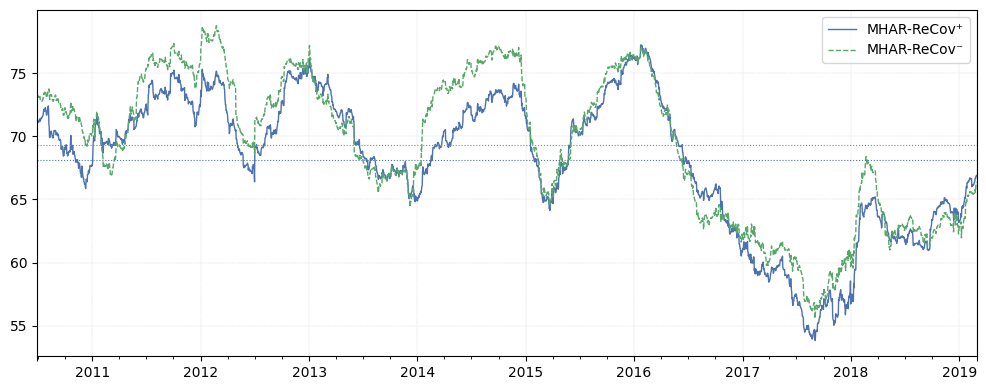

In [14]:
fig, ax = plt.subplots(figsize=(10,4))
tsi_pos['TSI'].plot(ax=ax, color="#4C72B0", lw=1, label="MHAR-ReCov⁺")
tsi_neg['TSI'].plot(ax=ax, color="#55A868", lw=1, ls="--", label="MHAR-ReCov⁻")
ax.axhline(tsi_pos['TSI'].mean(),  color="#4C72B0", ls=":", lw=.8)
ax.axhline(tsi_neg['TSI'].mean(),  color="#55A868", ls=":", lw=.8)
ax.legend(); ax.grid(ls=":", lw=.3); plt.tight_layout()


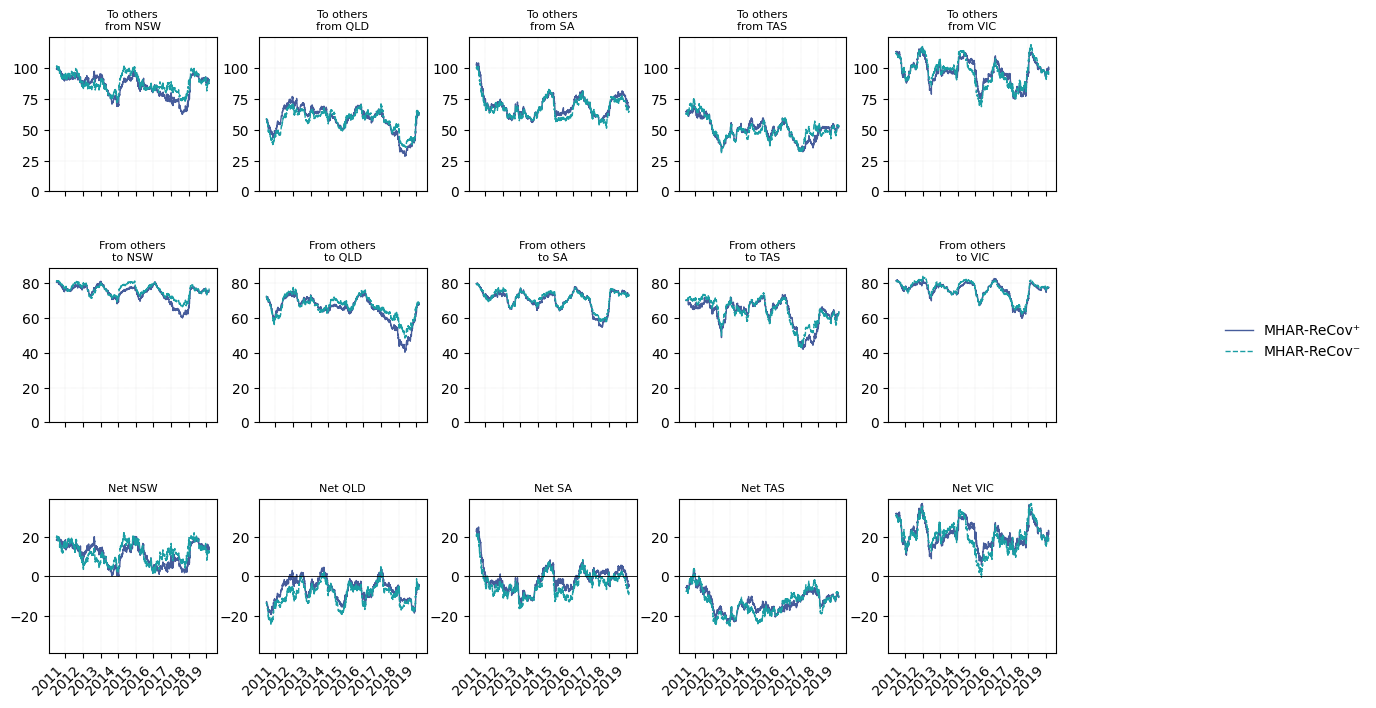

In [17]:
# -----------------------------------------------------------
# Facet grid ▸ directional spillovers  (Fig-6 style)
# -----------------------------------------------------------
def plot_directional_grid(panel_pos, panel_neg, *,
                          markets=None,
                          colors=("#6C7AE0", "#1AAA90"),      # +  ,- 
                          dashstyles=("-", "--"),              # +  ,- 
                          figsize_scale=2.6):
    """
    panel_pos / panel_neg:   the two 8-layer DataFrames you saved
                             (keys: 'TO_TOT','FROM_TOT','NET_TOT', …)
    markets            :     explicit ordering; if None use columns as-is
    colors, dashstyles :     styling for (+) and (-) series
    figsize_scale      :     width per facet in inches
    """
    to_p,   fr_p,   net_p  = (panel_pos[k] for k in ("TO_TOT","FROM_TOT","NET_TOT"))
    to_n,   fr_n,   net_n  = (panel_neg[k] for k in ("TO_TOT","FROM_TOT","NET_TOT"))

    # ----- choose / clean labels -------------------------------------
    mkts = markets or to_p.columns.tolist()
    disp = [m.replace("BZN|","").upper() for m in mkts]

    n_mk  = len(mkts)
    fig, axes = plt.subplots(nrows=3, ncols=n_mk,
                             figsize=(figsize_scale*n_mk, 8),
                             sharex="row", sharey=False,
                             gridspec_kw=dict(hspace=0.50, wspace=0.25))

    loc = mdates.YearLocator()
    fmt = mdates.DateFormatter("%Y")

    # ----- common y-limits -------------------------------------------
    y_to   = max(to_p.max().max(),   to_n.max().max())
    y_from = max(fr_p.max().max(),   fr_n.max().max())
    y_net  = max(abs(net_p).max().max(), abs(net_n).max().max())

    for j, (raw, lbl) in enumerate(zip(mkts, disp)):
        # –– TO others ––––––––––––––––––––––––––––––
        ax = axes[0, j]
        ax.plot(to_p.index, to_p[raw],  color=colors[0], ls=dashstyles[0], lw=1)
        ax.plot(to_n.index, to_n[raw],  color=colors[1], ls=dashstyles[1], lw=1)
        ax.set_title(f"To others\nfrom {lbl}", fontsize=8)
        ax.set_ylim(0, y_to*1.05)

        # –– FROM others ––––––––––––––––––––––––––––
        ax = axes[1, j]
        ax.plot(fr_p.index, fr_p[raw],  color=colors[0], ls=dashstyles[0], lw=1)
        ax.plot(fr_n.index, fr_n[raw],  color=colors[1], ls=dashstyles[1], lw=1)
        ax.set_title(f"From others\nto {lbl}", fontsize=8)
        ax.set_ylim(0, y_from*1.05)

        # –– NET (total) ––––––––––––––––––––––––––––
        ax = axes[2, j]
        ax.plot(net_p.index, net_p[raw], color=colors[0], ls=dashstyles[0], lw=1)
        ax.plot(net_n.index, net_n[raw], color=colors[1], ls=dashstyles[1], lw=1)
        ax.axhline(0, color="black", lw=.6)
        ax.set_title(f"Net {lbl}", fontsize=8)
        ax.set_ylim(-y_net*1.05, y_net*1.05)

        # –– x-axis formatting ––––––––––––––––––––––
        for r in range(3):
            ax = axes[r, j]
            ax.xaxis.set_major_locator(loc); ax.xaxis.set_major_formatter(fmt)
            if r < 2:                           # hide x-labels for top 2 rows
                ax.tick_params(axis="x", labelbottom=False)
            for lab in ax.get_xticklabels():
                lab.set_rotation(45); lab.set_ha("right")
            ax.grid(ls=":", lw=.3, color="#d0d0d0")

    # ----- single legend outside -------------------------------------
    fig.legend(["MHAR-ReCov⁺", "MHAR-ReCov⁻"],
               loc="center left",
               bbox_to_anchor=(1.02, 0.5),
               frameon=False)
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------
# call it – first build the two panels, then:
# -----------------------------------------------------------
plot_directional_grid(panel_pos, panel_neg,  # or leave out for “all”
                      colors=("#465C9B", "#1A9EA4"),
                      dashstyles=("-", "--"))
